In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

In [2]:
import torch
import torchaudio
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import random
#from plot_audio import plot_specgram, plot_waveform
os.getcwd()

/Users/jansta/miniconda3/envs/pytorch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jansta/miniconda3/envs/pytorch2/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


'/Users/jansta/learn/mri-AD'

(5120, 2)
Index(['image', 'label'], dtype='object')
(1280, 2)


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


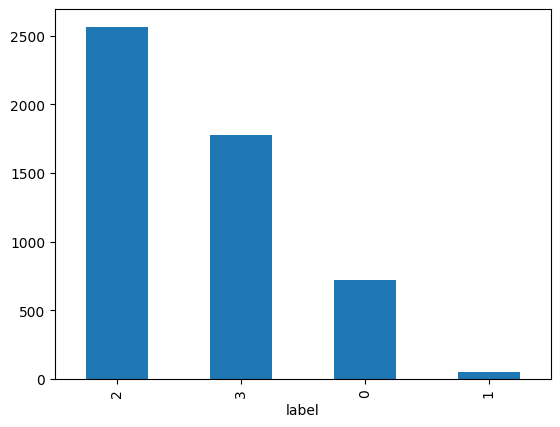

In [3]:
DATA_DIR = '/Users/jansta/learn/mri-AD/Data/'

# Load the parquet files
train_data = pd.read_parquet(os.path.join(DATA_DIR, 'train-00000-of-00001-c08a401c53fe5312.parquet'))
print(train_data.shape)
print(train_data.columns)

test_data = pd.read_parquet(os.path.join(DATA_DIR, 'test-00000-of-00001-44110b9df98c5585.parquet'))
print(test_data.shape)

train_data['label'].value_counts().plot(kind='bar')

train_data.head()


In [4]:
def convert_to_format(bytes_df):
    img_arr=np.frombuffer(bytes_df,dtype=np.uint8) # frombuffer is used to convert the bytes to np.array
    img=cv2.imdecode(img_arr,cv2.IMREAD_COLOR)    # here cv2 imdecode is used for readblity formate and IMREAD_COLOR is used for rgb color format image 
    return img

def get_img(df):
    images=[]
    for i in range(len(df)):
        inputt=df.iloc[i]['image']['bytes']
        cv_data=convert_to_format(inputt)
        images.append(cv_data)
    return images

In [5]:
train_data['image'] = get_img(train_data)
train_data['image'].iloc[0].shape
test_data['image'] = get_img(test_data)

Text(0.5, 1.0, '2')

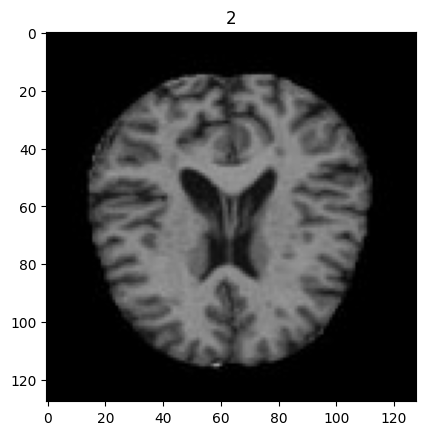

In [6]:
plt.imshow(train_data['image'][0])
plt.title(train_data['label'][0])

In [7]:
label_mapping = {
    0: 0,  # Mild_Demented -> Demented
    1: 0,  # Moderate_Demented -> Demented
    2: 2,  # Non_Demented -> Healthy
    3: 1   # Very_Mild_Demented -> Mild Demented
}

In [8]:
class AD_Dataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.transform = transform
        self.df = data_frame
         # Check unique values in the 'label' column before mapping
        print(f"Unique labels before mapping:{ self.df['label'].unique()}")

        # Apply binary label mapping to the 'label' column
        self.df['label'] = self.df['label'].map(label_mapping)

        # Verify label mapping (should  contain: 0, 1, 2)
        unique_labels = self.df['label'].unique()
        if not all(label in [0, 1, 2] for label in unique_labels):
            raise ValueError(f'Label inconsistency after mapping: {unique_labels}')
        print(f"Unique labels after mapping:{ self.df['label'].unique()}")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load the image array and binary label from the DataFrame
        image = self.df.iloc[idx]['image'].transpose()
        label = self.df.iloc[idx]['label']

        #print(f'image shape {image.shape}')

        # Convert image to tensor, add channel dimension, and apply transformations if any
        image = torch.tensor(image, dtype=torch.float32)  # Shape (1, height, width)
        label = torch.tensor(label, dtype=torch.long)  # Ensure label is long type for classification

        #print(f'image tensor size: {image.size()}')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [9]:
transform = transforms.Compose([
    #transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=1),
    #transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
    ])

In [10]:
train_dataset = AD_Dataset(train_data, transform=transform)
test_dataset = AD_Dataset(test_data, transform=transform)

Unique labels before mapping:[2 0 3 1]
Unique labels after mapping:[2 0 1]
Unique labels before mapping:[3 0 2 1]
Unique labels after mapping:[1 0 2]


In [11]:
# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
train_dataset[0][0].shape

torch.Size([1, 128, 128])

In [13]:
for i, (inputs, labels) in enumerate(train_loader):
    print(f'Batch {i+1}:')
    print(f'Inputs shape: {inputs.shape}')
    print(f'Labels shape: {labels.shape}')
    print(f'Labels: {labels}')
    break

Batch 1:
Inputs shape: torch.Size([8, 1, 128, 128])
Labels shape: torch.Size([8])
Labels: tensor([2, 0, 1, 2, 2, 2, 0, 2])


In [17]:
class ClassifNetXAI(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.feature_maps = None
        
        # First Convolutional Block
        self.conv_block1 = nn.Sequential(
            # First convolution: increase number of channels to 16
            nn.Conv2d(1, 16, kernel_size=3, padding=1), #input: (B, 1, H, W) output: (B, 16, H, W)
            nn.BatchNorm2d(16), # BatchNorm to stabilize learning
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # reduces height and width by 2
            
            # Second convolution: further increase channels to 32, also add BatchNorm
            nn.Conv2d(16, 32, kernel_size=3, padding=1), #output: (B, 32, H, W)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # reduces height and width by 2

            # Third convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Output: (B, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces height and width by 2 -> (B, 64, 8, 8)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output: (B, 64, 1, 1)

        # Fully connected block
        self.fc_block = nn.Sequential(
            nn.Flatten(),              # Flattens (B, 64, 1, 1) into (B, 64)
            nn.Linear(64, 64),         # Adjusted input features to match the flattened size
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 3)           # 3 == n_classes
        )
    
        
    def forward(self, x: torch.Tensor, store_feature_maps: bool = False) -> torch.Tensor:
        x = self.conv_block1(x)
        #x = self.conv_block2(x)
        
        if store_feature_maps:
            # Detaching feature maps for visualization (e.g., Grad-CAM)
            self.feature_maps = x.detach()
        # Global average pooling: converts (B, 128, H, W) to (B, 128, 1, 1)
        x = self.global_pool(x)
        x = self.fc_block(x)
        # Note: Do not apply an activation like softmax here if you're using CrossEntropyLoss
        return x


In [ ]:
## Create an  instance of the model:
#n_classes = len(chosen_labels)

NUM_EPOCHS = 300
model = ClassifNetXAI()
rate_l = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=rate_l)
losses_epoch_mean = []
for epoch in range(NUM_EPOCHS):
    losses_epoch = []
    for i, data in enumerate(train_loader):
        inputs, labels = data
        # Check for NaN loss
        if torch.isnan(inputs).any():
            print(f"NaN input at epoch {epoch}, batch {i}")
            i_err = inputs
            break
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Check for NaN loss
        if torch.isnan(loss):
            print(f"NaN loss at epoch {epoch}, batch {i}")
            l_err = loss
            break
        
        loss.backward()
        optimizer.step()
        losses_epoch.append(loss.item())
    
    losses_epoch_mean.append(np.mean(losses_epoch))
    if epoch % (int(NUM_EPOCHS/10)) == 0:
        print(f'Epoch {epoch}/{NUM_EPOCHS}, Loss: {np.mean(losses_epoch):.16f}')

Epoch 0/100, Loss: 0.9226937296800315
Epoch 10/100, Loss: 0.5494112067855894
Epoch 20/100, Loss: 0.2814355449401774
Epoch 30/100, Loss: 0.2066862667372334
Epoch 40/100, Loss: 0.1440310299440171
Epoch 50/100, Loss: 0.1277716472654447
Epoch 60/100, Loss: 0.1088711752375275
Epoch 70/100, Loss: 0.1012085901123101
Epoch 80/100, Loss: 0.1330261353707556
Epoch 90/100, Loss: 0.1108700521435821


In [ ]:
# y_val = []
# y_val_hat = []
# for i, data in enumerate(val_loader):
#     inputs, y_val_temp = data
#     with torch.no_grad():
#         y_val_hat_temp = model(inputs).round()
    
#     y_val.extend(y_val_temp.numpy())
#     y_val_hat.extend(y_val_hat_temp.numpy())

In [ ]:

# # Accuracy
# acc = accuracy_score(y_val, np.argmax(y_val_hat, axis=1))
# print(f'Accuracy: {acc*100:.2f} %')
# # confusion matrix
# cm = confusion_matrix(y_val, np.argmax(y_val_hat, axis=1))
sns.heatmap(cm, annot=True, xticklabels=chosen_labels, yticklabels=chosen_labels)


In [ ]:
#torch.save(model.state_dict(), f'mri_classification_model10_LR{rate_l}_a{acc*100:.0f}%.pth')